In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.layers import Concatenate, Input, LeakyReLU, BatchNormalization
import time
from numpy.random import seed

2023-03-22 12:50:45.976528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


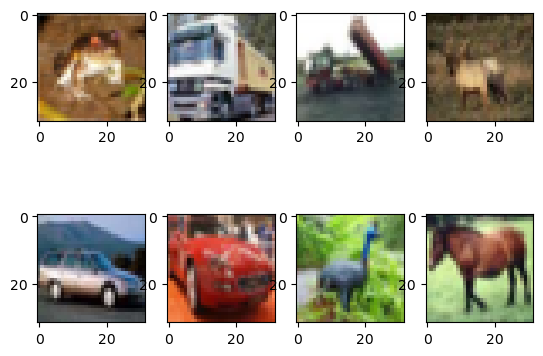

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [7]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [7]:
# Preprocess the images
norm_imgs = imgs/255.0  # Normalize pixel values between 0 and 1
clean_test_imgs = norm_imgs[:10000]
noisy_train_imgs = norm_imgs[10000:]

# Extracting the last 40,000 labels for training
noisy_train_labels = noisy_labels[10000:]

print(noisy_train_labels.shape)
print(noisy_train_imgs.shape)

(40000,)
(40000, 32, 32, 3)


In [ ]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(imgs):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # Preprocess the images

In [15]:
# Construct a CNN model
def cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=[32,32,3]),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [76]:
# Calculate time consumption
time0 = time.time()

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_train_imgs, noisy_train_labels, test_size=0.2, random_state=0)

# Train the model
model = cnn_model()
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Calculate the model size in bytes
# model_size = model.count_params() * 4 # Multiply by 4 for float32 data type

# Evaluate the model on test set
x_test = clean_test_imgs
y_test = clean_labels
test_loss, test_acc = model.evaluate(x_test, y_test)
time1 = time.time()

# print(f"Model size: {model_size/(1024 ** 2):.2f} MB")
print(f"Time taken (in mins) to run code: {(time1 - time0)/60}")
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Epoch 1/8
1000/1000 [==============================] - 33s 32ms/step - loss: 2.2847 - accuracy: 0.1350 - val_loss: 2.2932 - val_accuracy: 0.1430
Epoch 2/8
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2483 - accuracy: 0.1813 - val_loss: 2.2344 - val_accuracy: 0.2076
Epoch 3/8
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2275 - accuracy: 0.1985 - val_loss: 2.2278 - val_accuracy: 0.2144
Epoch 4/8
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2093 - accuracy: 0.2130 - val_loss: 2.2197 - val_accuracy: 0.2215
Epoch 5/8
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1913 - accuracy: 0.2252 - val_loss: 2.2154 - val_accuracy: 0.2260
Epoch 6/8
1000/1000 [==============================] - 33s 33ms/step - loss: 2.1726 - accuracy: 0.2372 - val_loss: 2.2192 - val_accuracy: 0.2244
Epoch 7/8
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1505 - accuracy: 0.2498 - val_loss: 2.2352 - val_ac

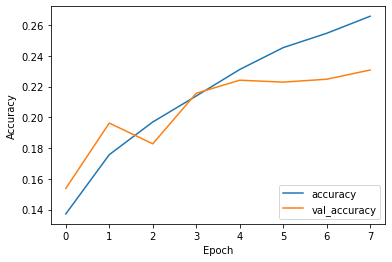

In [11]:
plt.plot(history.history['accuracy'], label='accuracy') 
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 2.3. Model II

In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

### Using pretrained model to train our model on clean data

In [17]:
# Calculate time consumption
time0 = time.time()

# Split the data into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(clean_test_imgs, clean_labels, 
                                                  test_size=0.2, random_state=0, stratify = clean_labels)

# Load pre-trained model
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Add classification layers
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)

# Compile model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_images, train_labels, epochs=10, batch_size=128)

# Make predictions on unlabeled data
#predictions = model.predict(test_images)

# Print predicted classes
#predicted_classes = np.argmax(predictions, axis=1)
#print(predicted_classes)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}") # 57.95

time1 = time.time()
print(f"Time taken (in mins) to run code: {(time1 - time0)/60}")

Epoch 1/10
63/63 [==============================] - 48s 739ms/step - loss: 2.0549 - accuracy: 0.2634
Epoch 2/10
63/63 [==============================] - 57s 904ms/step - loss: 1.7098 - accuracy: 0.3950
Epoch 3/10
63/63 [==============================] - 60s 957ms/step - loss: 1.5794 - accuracy: 0.4525
Epoch 4/10
63/63 [==============================] - 62s 980ms/step - loss: 1.4901 - accuracy: 0.4767
Epoch 5/10
63/63 [==============================] - 56s 890ms/step - loss: 1.4375 - accuracy: 0.5016
Epoch 6/10
63/63 [==============================] - 59s 937ms/step - loss: 1.3910 - accuracy: 0.5145
Epoch 7/10
63/63 [==============================] - 57s 903ms/step - loss: 1.3605 - accuracy: 0.5232
Epoch 8/10
63/63 [==============================] - 57s 901ms/step - loss: 1.3298 - accuracy: 0.5347
Epoch 9/10
63/63 [==============================] - 59s 944ms/step - loss: 1.2916 - accuracy: 0.5502
Epoch 10/10
63/63 [==============================] - 58s 929ms/step - loss: 1.2758 - accura

### Using above model to train model on all clean images and labels

In [20]:
# Calculate time consumption
np.random.seed(0)
tf.random.set_seed(0)

time0 = time.time()

# Train model
model.fit(clean_test_imgs, clean_labels, epochs=10, batch_size=128)

time1 = time.time()
print(f"Time taken (in mins) to run code: {(time1 - time0)/60}")

Epoch 1/10
79/79 [==============================] - 60s 749ms/step - loss: 1.8053 - accuracy: 0.3530
Epoch 2/10
79/79 [==============================] - 74s 940ms/step - loss: 1.4730 - accuracy: 0.4849
Epoch 3/10
79/79 [==============================] - 75s 944ms/step - loss: 1.3578 - accuracy: 0.5238
Epoch 4/10
79/79 [==============================] - 71s 904ms/step - loss: 1.2959 - accuracy: 0.5470
Epoch 5/10
79/79 [==============================] - 68s 855ms/step - loss: 1.2568 - accuracy: 0.5610
Epoch 6/10
79/79 [==============================] - 68s 864ms/step - loss: 1.2144 - accuracy: 0.5762
Epoch 7/10
79/79 [==============================] - 69s 880ms/step - loss: 1.1840 - accuracy: 0.5870
Epoch 8/10
79/79 [==============================] - 74s 939ms/step - loss: 1.1492 - accuracy: 0.5954
Epoch 9/10
79/79 [==============================] - 66s 836ms/step - loss: 1.1255 - accuracy: 0.6088
Epoch 10/10
79/79 [==============================] - 86s 1s/step - loss: 1.1000 - accuracy:

In [21]:
# Make predictions on unlabeled data
#predictions = model.predict(noisy_train_imgs) 
predictions = model.predict(norm_imgs)

# Print predicted classes
predicted_classes = np.argmax(predictions, axis=1)

1563/1563 [==============================] - 347s 222ms/step


In [22]:
print(predicted_classes[:20])

[6 9 8 4 8 6 2 7 0 8 2 7 7 9 1 9 9 3 6 1]


In [24]:
print(clean_labels[:20])

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]


In [25]:
sum = 0
for i in range(len(clean_labels)):
    if predicted_classes[i] == clean_labels[i]:
        sum = sum + 1
        
print(sum)

6613


In [30]:
sum = 0
for i in range(len(clean_labels)):
    if noisy_labels[i] == clean_labels[i]:
        sum = sum + 1
        
print(sum)

3968


In [28]:
label_count = []
for i in range(10):
    label_count.append(np.count_nonzero(predicted_classes[:10000]==i))
print(label_count)

[944, 1080, 880, 909, 791, 979, 1157, 994, 1224, 1042]


In [29]:
label_count = []
for i in range(10):
    label_count.append(np.count_nonzero(clean_labels==i))
print(label_count)

[1005, 974, 1032, 1016, 999, 937, 1030, 1001, 1025, 981]


### Using CNN model 1 on cleaned dataset

In [35]:
### Running cnn model

# Calculate time consumption
time0 = time.time()

predicted_labels = predicted_classes[10000:]

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_train_imgs, predicted_labels, 
                                                  test_size=0.2, random_state=0, stratify = predicted_labels)

# Train the model
model = cnn_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_val, y_val), callbacks=early_stopping)

# Calculate the model size in bytes
# model_size = model.count_params() * 4 # Multiply by 4 for float32 data type

# Evaluate the model on test set
x_test = clean_test_imgs
y_test = clean_labels
test_loss, test_acc = model.evaluate(x_test, y_test)
time1 = time.time()

# print(f"Model size: {model_size/(1024 ** 2):.2f} MB")
print(f"Time taken (in mins) to run code: {(time1 - time0)/60}")
print('Test accuracy: ', test_acc) 

Epoch 1/10
1000/1000 [==============================] - 75s 74ms/step - loss: 1.7955 - accuracy: 0.3518 - val_loss: 1.4799 - val_accuracy: 0.4875
Epoch 2/10
1000/1000 [==============================] - 80s 80ms/step - loss: 1.4667 - accuracy: 0.4837 - val_loss: 1.3421 - val_accuracy: 0.5418
Epoch 3/10
1000/1000 [==============================] - 76s 76ms/step - loss: 1.3575 - accuracy: 0.5290 - val_loss: 1.2277 - val_accuracy: 0.5705
Epoch 4/10
1000/1000 [==============================] - 72s 72ms/step - loss: 1.2926 - accuracy: 0.5482 - val_loss: 1.2200 - val_accuracy: 0.5677
Epoch 5/10
1000/1000 [==============================] - 74s 74ms/step - loss: 1.2532 - accuracy: 0.5624 - val_loss: 1.1765 - val_accuracy: 0.5839
Epoch 6/10
1000/1000 [==============================] - 73s 73ms/step - loss: 1.2221 - accuracy: 0.5725 - val_loss: 1.1103 - val_accuracy: 0.6133
Epoch 7/10
1000/1000 [==============================] - 70s 70ms/step - loss: 1.1874 - accuracy: 0.5846 - val_loss: 1.1555 -

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [9]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.